In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 5)
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['lines.linewidth'] = 1.5

np.random.seed(13)

df = pd.read_csv('../data/NVDA_returns.csv', parse_dates=['Date'], thousands=',')
df = df.sort_values('Date').reset_index(drop=True)
df = df.rename(columns={'Adj Close': 'Precio'})
df = df[['Date', 'Precio']].set_index('Date')

df['Log_Return'] = np.log(df['Precio'] / df['Precio'].shift(1))
df.dropna(inplace=True)

returns = df['Log_Return'].values

print(f"[OK]")

[OK]


# **Bloque II — Fundamentos Cuantitativos**
---
## **3.2 Probabilidad y Estadística Esencial**
### *Conceptos Fundamentales para Finanzas Cuantitativas*

**Objetivo de la clase:** Dominar los conceptos estadísticos fundamentales (esperanza, varianza, covarianza, correlación) y entender la incertidumbre inherente a la estimación muestral. Introduciremos la **Ley de los Grandes Números** y el **Teorema Central del Límite**, los dos pilares que conectan la probabilidad teórica con los datos reales del mercado.

**Estructura:**
1. **Esperanza** — Qué es, cómo se estima, y por qué en finanzas es un concepto más frágil de lo que parece.
   - **Momentos de Orden Superior** — La jerarquía de momentos y su fragilidad.
2. **Varianza y Volatilidad** — Medir la dispersión de los retornos y su papel central en el riesgo financiero.
3. **Covarianza y Correlación** — Cómo se relacionan dos activos y por qué importa para la construcción de carteras.
4. **Estimación Muestral e Incertidumbre** — La diferencia entre el parámetro verdadero y lo que medimos con datos finitos.
5. **Ley de los Grandes Números (LLN)** — La garantía teórica de convergencia.
6. **Teorema Central del Límite (CLT)** — por qué la media muestral siempre termina siendo Normal.

> **Prerequisito:** Notebook anterior — *3.1 Marco de Modelado del Mercado* (precios, log-retornos, GBM, Monte Carlo).

## Esperanza $\mathbb{E}[X]$

En el notebook anterior, estimábamos parámetros como $\mu$ directamente de los datos de NVDA. Pero ¿qué significa exactamente ese número?

La **Esperanza** de una variable aleatoria $X$ es el promedio ponderado de todos sus posibles resultados:

$$
\text{Esperanza Discreta:} \quad \mathbb{E}[X] = \sum_{i} x_i \, p_i \qquad \qquad
$$
Los resultados son finitos o contables, simplemente estamos haciendo un promedio ponderado.}
$$
\text{Esperanza Continua:} \quad \mathbb{E}[X] = \int_{-\infty}^{\infty} x \, f(x) \, dx
$$
El resultado puede ser cualquier valor decimal en un rango, la integral funciona como un sumatorio que se vuelve tan fino que se convierte en una curva conitnua.
Aparece f(x) y no p, porque la probabilidad de que un valor exacto ocurra (por ejemplo, que NVIDIA suba exactamente un $1.02837...\%$) es técnicamente cero, porque hay infinitas posibilidades decimales. Por eso, en lugar de probabilidades puntuales, usamos la Función de Densidad de Probabilidad ($f(x)$). Esta función nos indica cómo de 'probable' es una zona de la gráfica: cuanto más alta es la curva en un punto, más peso tiene ese valor de $x$ en el cálculo del promedio final.



**En finanzas**, $\mathbb{E}[r_t]$ representa el retorno promedio que *esperaríamos* obtener de un activo si pudiéramos repetir el experimento infinitas veces bajo las mismas condiciones. Es el concepto central en modelos como CAPM, Markowitz, Value at Risk(VaR), Black-Scholes...

**El problema fundamental:** Nunca observamos $\mathbb{E}[X]$ directamente. Solo podemos estimar $\hat{\mu}$ con datos finitos.

In [7]:
# ej.1 Esperanza de un dado justo, caso simple donde conocemos la distribución exacta
valores = np.array([1, 2, 3, 4, 5, 6])
probabilidades = np.array([1/6] * 6)
E_dado = np.sum(valores * probabilidades)
print(f"E[Dado_justo] = {E_dado}")

# ej2. Media muestral de los retornos de NVDA, NO conocemos la distribución real, solo tenemos datos
mu_hat = returns.mean()
mu_anual = mu_hat * 252

print(f"E[rₜ] (NVDA): μ_diaria= {mu_hat:.6f}, μ_diaria= {mu_hat:.6f}, Basada en n = {len(returns)} observaciones")

E[Dado_justo] = 3.5
E[rₜ] (NVDA): μ_diaria= 0.001218, μ_diaria= 0.001218, Basada en n = 6571 observaciones


¿Es esta media muestral μ = E[rₜ]? No necesariamente. Es solo una ESTIMACIÓN.
Como no conocemos no conocemos la distribución real generadora de los datos ($g(x)$), debemos hacer una estimación, y lo que usamos en este caso fue la media muestral como nuestra mejor estimación posible.

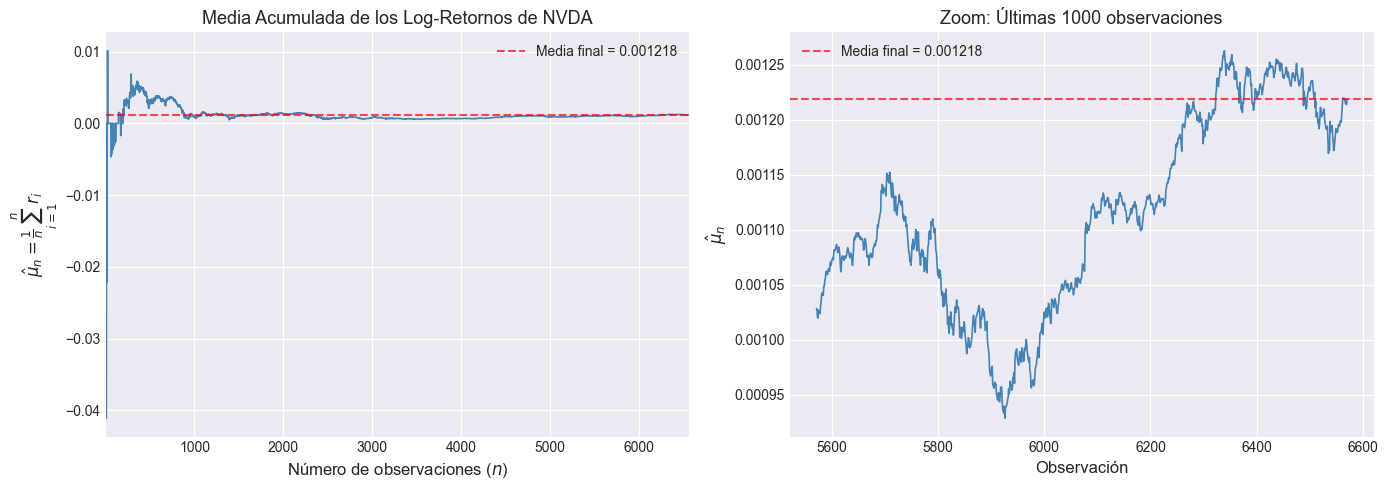

In [9]:
# converge la media muestral? Visualizamos la media acumulada conforme añadimos observaciones

cumulative_mean = np.cumsum(returns) / np.arange(1, len(returns) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(np.arange(1, len(returns)+1), cumulative_mean, color='steelblue', linewidth=1.2)
axes[0].axhline(y=mu_hat, color='red', linestyle='--', alpha=0.7, label=f'Media final = {mu_hat:.6f}')
axes[0].set_title('Media Acumulada de los Log-Retornos de NVDA', fontsize=13)
axes[0].set_xlabel('Número de observaciones ($n$)')
axes[0].set_ylabel('$\\hat{\\mu}_n = \\frac{1}{n}\\sum_{i=1}^{n} r_i$')
axes[0].legend()
axes[0].set_xlim([1, len(returns)])

#zoom en n obsv
n_zoom = 1000
axes[1].plot(np.arange(len(returns)-n_zoom, len(returns)), cumulative_mean[-n_zoom:], color='steelblue', linewidth=1.2)
axes[1].axhline(y=mu_hat, color='red', linestyle='--', alpha=0.7, label=f'Media final = {mu_hat:.6f}')
axes[1].set_title(f'Zoom: Últimas {n_zoom} observaciones', fontsize=13)
axes[1].set_xlabel('Observación')
axes[1].set_ylabel('$\\hat{\\mu}_n$')
axes[1].legend()

plt.tight_layout()
plt.show()

La media parece converger... pero ¿a qué valor?

Con 5000 observaciones más, ¿seguiría moviéndose?
Esta es la pregunta central que abordaremos al final de la libreta.

### Momentos de Orden Superior

La esperanza $\mathbb{E}[X]$ es el **primer momento** de la distribución. Pero la función generadora de momentos $M(t) = \mathbb{E}[e^{tX}]$ nos da acceso a toda la jerarquía mediante sus derivadas:

$$
M^{(n)}(0) = \mathbb{E}[X^n]
$$

**Interpretación:** La $n$-ésima derivada de $M$ evaluada en $t=0$ es igual a la Esperanza de $X$ elevado a la $n$.

Esto nos da los "ingredientes" para los estadísticos clave:
* $n=1$: $\mathbb{E}[X^1]$ $\rightarrow$ **Media** (Esperanza).
* $n=2$: $\mathbb{E}[X^2]$ $\rightarrow$ Materia prima para la **Varianza** ($\text{Var} = \mathbb{E}[X^2] - (\mathbb{E}[X])^2$).
* $n=3$: $\mathbb{E}[X^3]$ $\rightarrow$ Materia prima para la **Asimetría** (Skewness).
* $n=4$: $\mathbb{E}[X^4]$ $\rightarrow$ Materia prima para la **Curtosis** (Fat Tails).



#### La Fragilidad Jerárquica
Hay una dependencia fundamental: **si el primer momento (la media) es inestable, todos los momentos superiores también lo son.**

Esto tiene consecuencias profundas para la modelización:
1.  **Efecto Dominó:** Los momentos superiores se construyen *encima* de los inferiores. Por ejemplo, para calcular la Varianza (riesgo), necesitas restar la Media. Si tu estimación de la Media ($\mu$) es errónea, tu cálculo de riesgo será erróneo automáticamente.
2.  **Herencia de Error:** Todos los modelos financieros (desde Sharpe Ratio hasta Value at Risk) que usan estos estadísticos heredan esta fragilidad. Cuanto más alto subimos en la jerarquía (curtosis), más datos necesitamos y más error acumulamos.
---

## Varianza y Volatilidad

La **Varianza** mide cuánto se dispersan los valores alrededor de la media:

$$
\text{Var}(X) = \mathbb{E}\left[(X - \mu)^2\right] = \mathbb{E}[X^2] - \left(\mathbb{E}[X]\right)^2
$$

La **Desviación Estándar** $\sigma = \sqrt{\text{Var}(X)}$ es la métrica de riesgo más usada en finanzas. En el contexto de retornos financieros, *volatilidad* y desviación estándar son prácticamente sinónimos.

#### ¿Por qué la varianza y no otra medida de dispersión?

1. **Matemáticamente tratable:** El cuadrado hace que la función sea diferenciable y convexa, ideal para la optimización de carteras (Markowitz), entonces como necesitamos usar cálculo diferencial (derivadas), el cuadrado es perfecto.
2. **Conecta con la distribución Normal:** Si $r_t \sim \mathcal{N}(\mu, \sigma^2)$, entonces $\mu$ y $\sigma^2$ describen *completamente* la distribución.
3. **Anualización:** $\sigma_{\text{anual}} = \sigma_{\text{diaria}} \times \sqrt{252}$.

#### Estimator Poblacional vs. Muestral

$$
\text{Poblacional:} \quad \sigma^2 = \mathbb{E}[(X-\mu)^2] \qquad \text{Muestral:} \quad \hat{\sigma}^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2
$$

El $n-1$ en el denominador (corrección de Bessel) es necesario porque al usar $\bar{x}$  (media muestral) en vez de $\mu$(media verdadera), subestimamos sistemáticamente la varianza — la muestra siempre está más "cerca" de su propia media que de la media verdadera.

Estadísticos de dispersión de NVDA (log-retornos diarios):
Varianza muestral (σ̂²) = 0.00188548
Desv. Estándar diaria (σ̂)= 0.043422
Volatilidad anualizada= 0.6893 (68.93%)


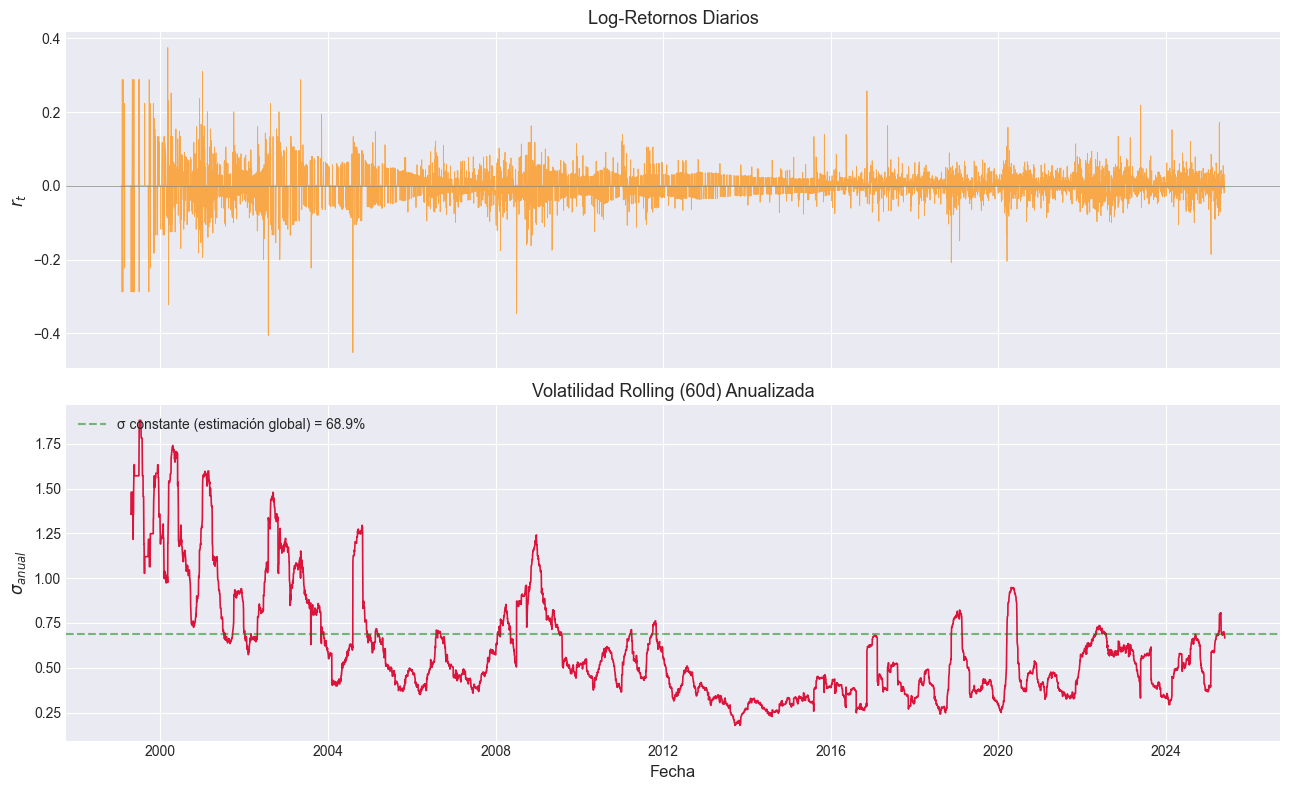

In [11]:
# Varianza y Volatilidad de NVDA
sigma_hat = returns.std(ddof=1)  # ddof=1 → corrección de Bessel
sigma_anual = sigma_hat * np.sqrt(252)
var_hat = sigma_hat ** 2

print("Estadísticos de dispersión de NVDA (log-retornos diarios):")
print(f"Varianza muestral (σ̂²) = {var_hat:.8f}")
print(f"Desv. Estándar diaria (σ̂)= {sigma_hat:.6f}")
print(f"Volatilidad anualizada= {sigma_anual:.4f} ({sigma_anual*100:.2f}%)")

# cómo evoluciona la volatilidad en ventanas móviles
window = 60  # 60 días ~ 3 meses
rolling_vol = df['Log_Return'].rolling(window).std() * np.sqrt(252)

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

axes[0].plot(df.index, df['Log_Return'], color='darkorange', linewidth=0.6, alpha=0.7)
axes[0].set_title('Log-Retornos Diarios', fontsize=13)
axes[0].set_ylabel('$r_t$')
axes[0].axhline(y=0, color='gray', linewidth=0.5)

axes[1].plot(df.index, rolling_vol, color='crimson', linewidth=1.2)
axes[1].axhline(y=sigma_anual, color='green', linestyle='--', alpha=0.5, label=f'σ constante (estimación global) = {sigma_anual*100:.1f}%')
axes[1].set_title(f'Volatilidad Rolling ({window}d) Anualizada', fontsize=13)
axes[1].set_ylabel('$\\sigma_{anual}$')
axes[1].set_xlabel('Fecha')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()
#La volatilidad NO es constante y el GBM asume σ constante, esta es una de sus limitaciones principales

Hemos calculado que la volatilidad anualizada de NVDA es **68.93%**.

**1. Retornos Diarios:**
* Aquí vemos el "ruido" del mercado día a día.
* **Observación Clave:** Noten que los días de grandes movimientos (picos altos) no están distribuidos aleatoriamente de forma uniforme. Se agrupan. Hay épocas de mayor volatilidad (años 2000-2002) y épocas de "calma" (2012-2015).

**2. Panel Inferior (Volatilidad Rolling vs. Promedio):**
* **La Línea Verde (Teoría):** Es nuestro 68.93%. Es la estimación estática que usaría un modelo simple.
* **La Línea Roja (Realidad):** Es la volatilidad recalculada cada 60 días (trimestralmente). Muestra el "pulso" real del mercado. Esta es la que estiman modelos ARCH/GARCH.

Esta gráfica demuestra un hecho estilizado famoso en finanzas, observado por Mandelbrot:
> *"Grandes cambios tienden a ser seguidos por grandes cambios, y pequeños cambios por pequeños cambios."*

**La trampa del promedio:**
* Si miran el año 2001, la volatilidad real (roja) llegó al **175%**. Si hubieras usado el promedio histórico del 69% para gestionar tu riesgo, habrías subestimado el peligro por la mitad y probablemente habrías quebrado.
* Por el contrario, en 2014, la volatilidad bajó al **30%**. Usar el 69% ahí habría sido ser demasiado conservador.

> **Conclusión:**
> La volatilidad no es una constante ($\sigma$), es un proceso estocástico ($\sigma_t$) que cambia con el tiempo.
> * **GBM:** Asume $\sigma$ constante (Línea Verde). Útil para aproximaciones rápidas.
> * **Modelos Avanzados (GARCH / Heston):** Intentan predecir la curva (Línea Roja).

## Covarianza y Correlación

Cuando pasamos de un **solo activo** a una **cartera**, necesitamos entender cómo se mueven los activos *entre sí*.

### Covarianza

La **Covarianza** mide la tendencia de dos variables a moverse en la misma dirección:

$$
\text{Cov}(X, Y) = \mathbb{E}\left[(X - \mu_X)(Y - \mu_Y)\right] = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y]
$$

- $\text{Cov}(X,Y) > 0$: Tienden a subir y bajar juntos.
- $\text{Cov}(X,Y) < 0$: Cuando uno sube, el otro tiende a bajar.
- $\text{Cov}(X,Y) = 0$: No hay relación lineal (pero puede haber relación no lineal).

### Correlación de Pearson

La correlación es la covarianza **normalizada**, lo que permite comparar la fuerza de la relación en una escala de $[-1, +1]$:

$$
\rho_{X,Y} = \frac{\text{Cov}(X,Y)}{\sigma_X \, \sigma_Y} \quad \in [-1, +1]
$$

### ¿Por qué importa en finanzas?

La **varianza de una cartera** de dos activos con pesos $w_1$ y $w_2$ es:

$$
\sigma_p^2 = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2 w_1 w_2 \, \text{Cov}(R_1, R_2)
$$

Si la correlación entre activos es **negativa**, el término cruzado **reduce** el riesgo total de la cartera. Este es el principio fundamental de la **diversificación**.

=== Covarianza y Correlación ===
Cov(A, B)    = 0.00112285
σ_A          = 0.043419
σ_B          = 0.043199
ρ(A, B)      = Cov/(σ_A·σ_B) = 0.5986
ρ objetivo   = 0.6


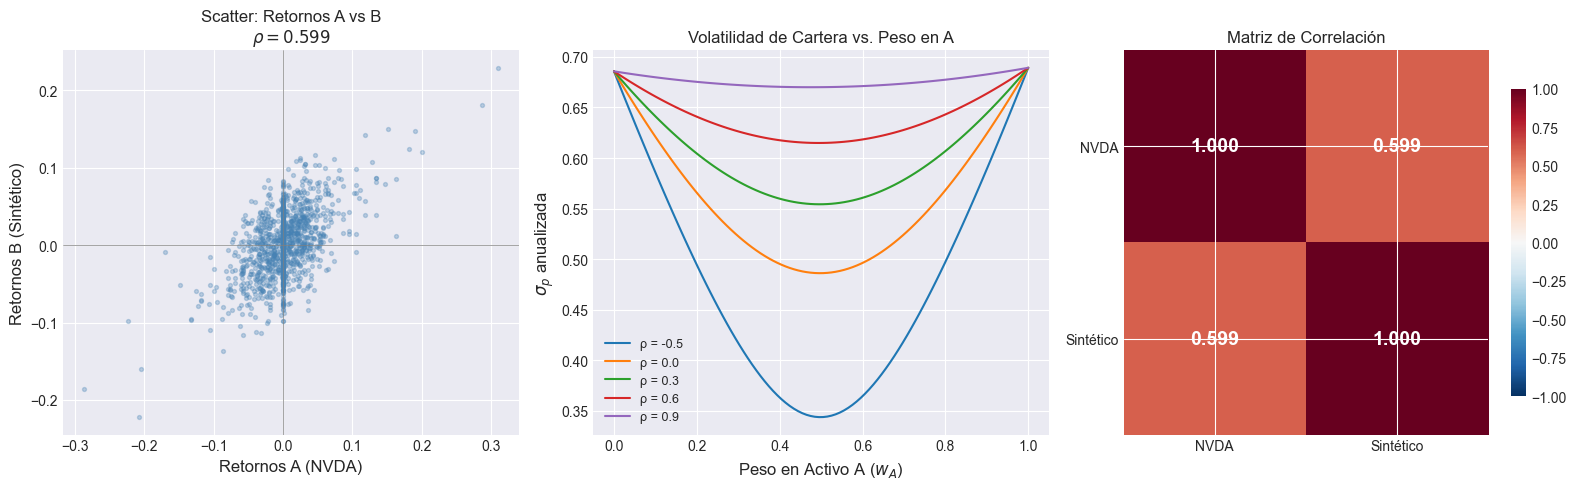

In [17]:
# Simulamos un segundo activo para demostrar covarianza y correlación
# Activo A: NVDA real. 
# Activo B: sintetico con correlación controlada.

rho_target = 0.6  # correlation objetivo entre A y B

# Generamos retornos de B correlacionados con A usando descomposición de Cholesky
z_independent = np.random.standard_normal(len(returns))
returns_B = rho_target * returns + np.sqrt(1 - rho_target**2) * z_independent * returns.std()
#stats
cov_AB = np.cov(returns, returns_B)[0, 1]
corr_AB = np.corrcoef(returns, returns_B)[0, 1]

print("=== Covarianza y Correlación ===")
print(f"Cov(A, B)    = {cov_AB:.8f}")
print(f"σ_A          = {returns.std():.6f}")
print(f"σ_B          = {returns_B.std():.6f}")
print(f"ρ(A, B)      = Cov/(σ_A·σ_B) = {corr_AB:.4f}")
print(f"ρ objetivo   = {rho_target}")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].scatter(returns[::5], returns_B[::5], alpha=0.3, s=8, color='steelblue')
axes[0].set_title(f'Scatter: Retornos A vs B\n$\\rho = {corr_AB:.3f}$', fontsize=12)
axes[0].set_xlabel('Retornos A (NVDA)')
axes[0].set_ylabel('Retornos B (Sintético)')
axes[0].axhline(0, color='gray', linewidth=0.5)
axes[0].axvline(0, color='gray', linewidth=0.5)

# Efecto de la correlación en la varianza de la cartera
weights_A = np.linspace(0, 1, 100)
weights_B = 1 - weights_A
sigma_A = returns.std() * np.sqrt(252)
sigma_B = returns_B.std() * np.sqrt(252)

for rho_test in [-0.5, 0.0, 0.3, 0.6, 0.9]:
    port_var = (weights_A**2 * sigma_A**2 + weights_B**2 * sigma_B**2 + 2 * weights_A * weights_B * rho_test * sigma_A * sigma_B)
    port_sigma = np.sqrt(port_var)
    axes[1].plot(weights_A, port_sigma, linewidth=1.5, label=f'ρ = {rho_test}')

axes[1].set_title('Volatilidad de Cartera vs. Peso en A', fontsize=12)
axes[1].set_xlabel('Peso en Activo A ($w_A$)')
axes[1].set_ylabel('$\\sigma_p$ anualizada')
axes[1].legend(fontsize=9)

# Matriz de correlación
corr_matrix = np.corrcoef(returns, returns_B)
im = axes[2].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['NVDA', 'Sintético'])
axes[2].set_yticklabels(['NVDA', 'Sintético'])
axes[2].set_title('Matriz de Correlación', fontsize=12)
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, f'{corr_matrix[i,j]:.3f}', ha='center', va='center', fontsize=14, fontweight='bold', color='white' if abs(corr_matrix[i,j]) > 0.5 else 'black')
plt.colorbar(im, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.show()

### El Poder de la Correlación

Para entender cómo interactúan los activos, hemos creado un activo sintético (B) que tiene una correlación de $\rho \approx 0.6$ con NVIDIA (A). Analicemos los tres paneles generados:

**1. El Scatter Plot:**
* Cada punto azul es un día. Muestra el retorno de NVDA (Eje X) frente al retorno del Activo B (Eje Y).
* Vemos una "nube" inclinada hacia arriba.
    * Esto confirma la **correlación positiva** ($\rho > 0$). Cuando NVDA sube, el activo B *tiende* a subir.
    * Si fuera una línea recta perfecta, la correlación sería 1.
    * Si fuera una bola redonda sin dirección, la correlación sería 0.
    * El hecho de que sea una nube dispersa indica que hay **ruido idiosincrático**: se mueven juntos, pero no son gemelos idénticos.

**2. La Curva de la Diversificación:**
Esta es la gráfica más importante de la Teoría Moderna de Carteras (MPT).
* **Eje X:** Cuánto dinero ponemos en NVIDIA ($w_A$).
* **Eje Y:** El riesgo total de la cartera ($\sigma_p$).

**¿Qué nos dice la curva?** ($\rho$ indica correlacion)
Observen la línea azul ($\rho = -0.5$) o la naranja ($\rho = 0.0$):
* Si inviertes 100% en A o 100% en B, tienes un riesgo alto.
* Pero si combinas ambos (ej. 50/50), el riesgo **cae drásticamente**, quedando por debajo del riesgo individual de cualquiera de los dos activos.
* **La Lección:** Siempre que la correlación sea menor a 1 ($\rho < 1$), combinar activos reduce el riesgo total.
    * La línea morada ($\rho = 0.9$) es casi recta: Si los activos son casi iguales, diversificar no sirve de nada.
    * La línea azul ($\rho = -0.5$) tiene una curva profunda: Si los activos se "pelean" (uno sube cuando el otro baja), el riesgo se cancela mutuamente. Muestra el poder extremo de la diversificación. Combinando dos activos muy volátiles, creamos una cartera muy segura (el punto más bajo de la curva).

**3. La Matriz de Correlación** 
* Es el estándar de la industria para resumir estas relaciones.
* **Diagonal (1.0):** Un activo siempre tiene correlación perfecta consigo mismo.
* **Off-Diagonal (0.598):** Es el número clave que calculamos. Este número único resume toda la información de la nube de puntos de la izquierda.

## Estimación Muestral e Incertidumbre

### Parámetro vs. Estimador

En el notebook anterior (3.1), calculábamos $\hat{\mu}$ y $\hat{\sigma}$ de NVDA y los usábamos como si fueran la verdad para simular el GBM. Pero estos no son los valores "verdaderos" — son **estimadores**, funciones de datos finitos.

| Concepto | Símbolo | Descripción |
|----------|---------|-------------|
| Parámetro poblacional | $\mu$, $\sigma$ | Valor verdadero del proceso generador (desconocido) |
| Estimador muestral | $\hat{\mu}$, $\hat{\sigma}$ | Función de los datos observados (variable aleatoria) |
| Estimación | $\hat{\mu} = 0.0015$ | Un número concreto calculado de una muestra particular |

#### Los estimadores son variables aleatorias

Esto es clave: si tuviéramos otro período de datos de NVDA, obtendríamos un $\hat{\mu}$ diferente. La pregunta no es "¿cuánto vale la media?", sino: **¿cuál es la distribución de $\hat{\mu}$?**

### Error Estándar: la incertidumbre del estimador

El **Error Estándar** de la media muestral cuantifica esta incertidumbre:

$$
\text{SE}(\hat{\mu}) = \frac{\hat{\sigma}}{\sqrt{n}}
$$

A medida que $n$ crece, la incertidumbre disminuye como $\frac{1}{\sqrt{n}}$. Pero ojo: necesitas **4 veces más datos** para reducir el error estándar a la mitad.

### ¿Es real nuestro retorno?

Hasta ahora hemos calculado que el retorno medio diario ($\hat{\mu}$) de NVIDIA es positivo. Pero, **¿podemos confiar en ese número?**

En estadística, cualquier estimación tiene un **Error Estándar (SE)**.

#### Interpretación de los Resultados
El código nos calcula un **Intervalo de Confianza (IC) al 95%**.
Esto significa: *"Estamos un 95% seguros de que el verdadero retorno esperado de NVIDIA cae dentro de este rango"*.

**El "Test del Cero":**
Lo más importante para un Quant es mirar si el intervalo **incluye el 0**.
* Si el IC es $[ -0.1\%, +0.3\% ]$, el 0 está dentro. **No podemos afirmar estadísticamente que el activo gane dinero.** Podría ser simplemente ruido aleatorio con suerte.
* Si el IC es $[ +0.1\%, +0.3\% ]$, el 0 está fuera. Tenemos evidencia estadística de que el retorno es positivo (Alpha significativo).

---

### La asimetría entre estimar $\mu$ y estimar $\sigma$

Hay un fenómeno crucial que debemos entender:

- **La volatilidad ($\sigma$) se estima con relativa precisión** — ya con unas semanas de datos diarios tenemos una estimación razonable. Esto es porque cada observación individual nos da información directa sobre $\sigma$ a través de la magnitud del movimiento.

- **La media ($\mu$) es extremadamente difícil de estimar** — porque la señal ($\mu$ diaria $\approx$ 0.001) está enterrada bajo el ruido ($\sigma$ diaria $\approx$ 0.03). La relación **señal/ruido** es:

$$
\text{SNR} = \frac{|\mu|}{\sigma / \sqrt{n}} = \frac{|\mu| \sqrt{n}}{\sigma}
$$

Para NVDA, necesitaríamos del orden de $\left(\frac{\sigma}{\mu}\right)^2 \approx$ **miles de años** de datos diarios para estimar $\mu$ con la misma precisión relativa con la que estimamos $\sigma$ en semanas.

> **Esto explica por qué el GBM del notebook anterior captura bien la volatilidad pero no predice la dirección del mercado: $\hat{\sigma}$ es confiable, $\hat{\mu}$ no.**

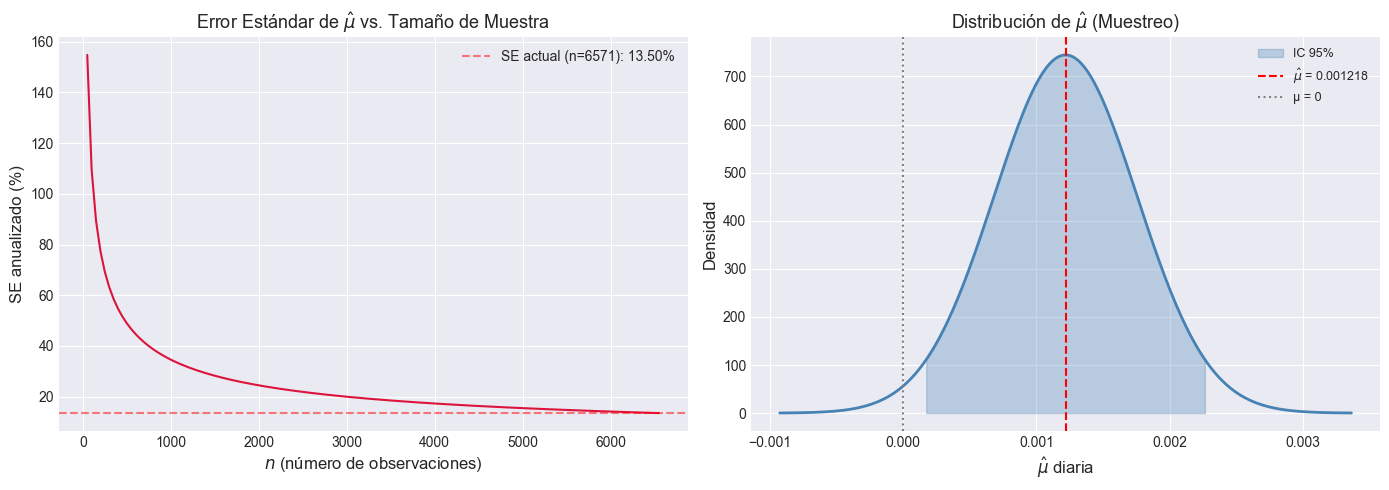

In [32]:
# Error stdard e intervalos de Confianza
n = len(returns)
se_mu = sigma_hat / np.sqrt(n)

# Intervalo de confianza al 95% para la media diaria
z_95 = 1.96
ci_lower = mu_hat - z_95 * se_mu
ci_upper = mu_hat + z_95 * se_mu

sample_sizes = np.arange(50, n+1, 50)
se_values = sigma_hat / np.sqrt(sample_sizes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error estándar vs n
axes[0].plot(sample_sizes, se_values * 252 * 100, color='crimson', linewidth=1.5)
axes[0].set_title('Error Estándar de $\\hat{\\mu}$ vs. Tamaño de Muestra', fontsize=13)
axes[0].set_xlabel('$n$ (número de observaciones)')
axes[0].set_ylabel('SE anualizado (%)')
axes[0].axhline(y=se_mu * 252 * 100, color='red', linestyle='--', alpha=0.5, 
                label=f'SE actual (n={n}): {se_mu*252*100:.2f}%')
axes[0].legend()

# Distribución del estimador de la media (concepto CLT preview)
x_grid = np.linspace(mu_hat - 4*se_mu, mu_hat + 4*se_mu, 200)
pdf_mu = stats.norm.pdf(x_grid, mu_hat, se_mu)
axes[1].plot(x_grid, pdf_mu, color='steelblue', linewidth=2)
axes[1].fill_between(x_grid, pdf_mu, where=(x_grid >= ci_lower) & (x_grid <= ci_upper),
                     alpha=0.3, color='steelblue', label='IC 95%')
axes[1].axvline(x=mu_hat, color='red', linestyle='--', label=f'$\\hat{{\\mu}}$ = {mu_hat:.6f}')
axes[1].axvline(x=0, color='gray', linestyle=':', label='μ = 0')
axes[1].set_title('Distribución de $\\hat{\\mu}$ (Muestreo)', fontsize=13)
axes[1].set_xlabel('$\\hat{\\mu}$ diaria')
axes[1].set_ylabel('Densidad')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

### Análisis de las Gráficas

**1. Gráfico Izquierdo:**
Este gráfico muestra cómo baja nuestro error a medida que tenemos más datos ($n$).
* **La forma de la curva:** Cae rápido al principio, pero luego se aplana.
* **La Ley de $\sqrt{n}$:** Para reducir el error a la **mitad**, no necesitas el doble de datos... ¡necesitas **4 veces** más datos!
* Esto explica por qué en finanzas necesitamos décadas de historia para estar seguros de la media, mientras que la volatilidad se estima rápido.

**2. Gráfico Derecho:**
Esta campana **NO** es la distribución de los retornos (que vimos antes).
* Es la **Distribución del Estimador $\hat{\mu}$**. Nos dice dónde creemos que está la verdadera media.
* **Zona Azul Sombreada:** Es nuestra red. Creemos al 95% que el verdadero valor está ahí.
* **Línea Punteada Gris ($\mu=0$):** Si la zona azul toca o cruza esta línea, estamos en problemas: no podemos descartar que el activo sea neutro (ni gane ni pierda) y que lo que vemos sea pura suerte.

## Ley de los Grandes Números (LLN)

### Enunciado Formal

Dada una secuencia de variables aleatorias $X_1, X_2, \ldots$ independientes e idénticamente distribuidas (i.i.d.) con $\mathbb{E}[X_i] = \mu$:

$$
\boxed{\frac{1}{n}\sum_{i=1}^{n} X_i \xrightarrow{n \to \infty} \mu}
$$

Existen dos versiones:
- **LLN Débil** (convergencia en probabilidad): $P\left(|\bar{X}_n - \mu| > \varepsilon\right) \to 0$ para todo $\varepsilon > 0$.
- **LLN Fuerte** (convergencia casi segura): $P\left(\lim_{n\to\infty} \bar{X}_n = \mu\right) = 1$.

### Aplicación: Convergencia de Monte Carlo

En el notebook anterior, vimos que el promedio de $M$ trayectorias GBM converge al valor esperado teórico $\mathbb{E}[S_T]$. Esto funciona **gracias a la LLN**:

$$
\frac{1}{M}\sum_{i=1}^{M} S_T^{(i)} \xrightarrow{M \to \infty} \mathbb{E}[S_T]
$$

### El requisito oculto: distribución idéntica

La LLN requiere que todas las $X_i$ vengan de la **misma distribución**. En finanzas, esto se traduce en asumir que los retornos son estacionarios — que los parámetros $\mu$ y $\sigma$ no cambian con el tiempo.

Ya hemos visto (volatilidad rolling) que esto **no se cumple** en la realidad. Veremos las consecuencias al final del notebook.

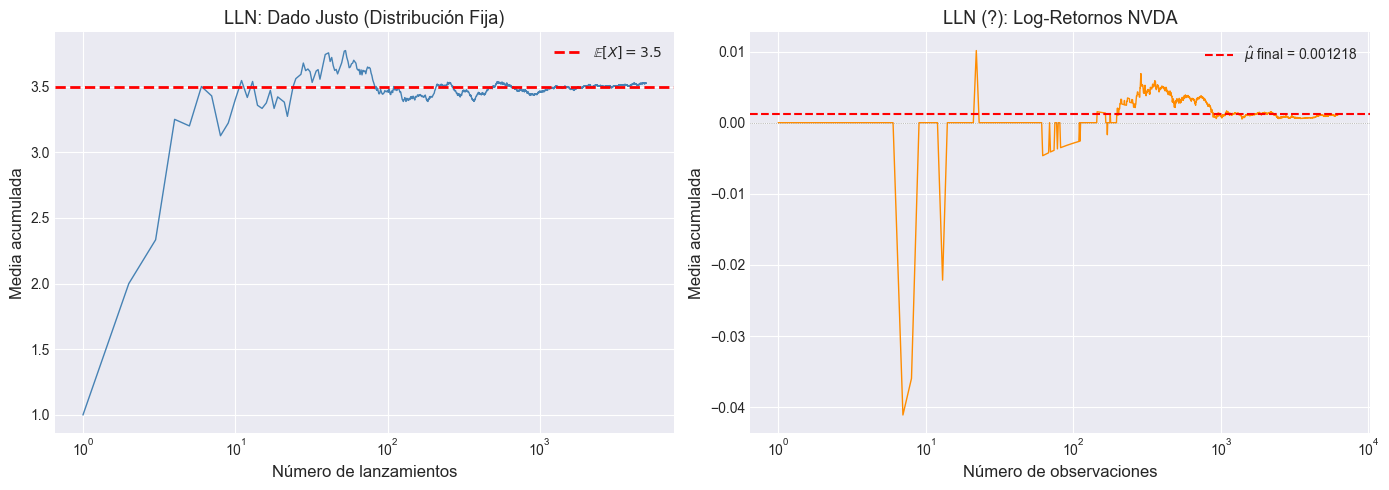

In [21]:
# LLN : Dado vs. Retornos

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#LLN dado
n_rolls = 5000
rolls = np.random.randint(1, 7, size=n_rolls)
cumulative_mean_dice = np.cumsum(rolls) / np.arange(1, n_rolls + 1)

axes[0].plot(np.arange(1, n_rolls+1), cumulative_mean_dice, color='steelblue', linewidth=1)
axes[0].axhline(y=3.5, color='red', linestyle='--', linewidth=2, label='$\\mathbb{E}[X] = 3.5$')
axes[0].set_title('LLN: Dado Justo (Distribución Fija)', fontsize=13)
axes[0].set_xlabel('Número de lanzamientos')
axes[0].set_ylabel('Media acumulada')
axes[0].set_xscale('log')
axes[0].legend()

# LLN w/NVDA (¿distribución fija?)
axes[1].plot(np.arange(1, len(returns)+1), cumulative_mean, color='darkorange', linewidth=1)
axes[1].axhline(y=mu_hat, color='red', linestyle='--', linewidth=1.5, label=f'$\\hat{{\\mu}}$ final = {mu_hat:.6f}')
axes[1].axhline(y=0, color='gray', linestyle=':', linewidth=0.5)
axes[1].set_title('LLN (?): Log-Retornos NVDA', fontsize=13)
axes[1].set_xlabel('Número de observaciones')
axes[1].set_ylabel('Media acumulada')
axes[1].set_xscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

Estas dos gráficas comparan cómo funciona la LLN en un entorno controlado vs uno financiero.

**1. Izquierda: Dado Justo**
* **El escenario:** Lanzamos un dado virtual. Conocemos la probabilidad exacta (1/6 por cara) y sabemos que el dado no cambia de forma a mitad del experimento (es estacionario).
* **Lo que vemos:**
    * Al principio hay ruido (la línea azul salta).
    * Rápidamente, la línea se pega a la línea roja punteada ($E[X]=3.5$).
    * **Conclusión:** La convergencia es rápida, limpia y garantizada. Es el triunfo de la teoría.

**2. Derecha: Retornos de NVDA (mundo real)**
* **El escenario:** Los retornos diarios de una acción, no conocemos la distribución real y el dado~la empresa cambia con los años.
* **Lo que vemos:**
    * **Caos Inicial:** Los picos violentos al inicio. Unos pocos días malos arrastran el promedio masivamente hacia abajo.
    * **Convergencia "Sucia":** Aunque eventualmente se acerca a la media final ($0.0012$), el camino es mucho más basto que con el dado.
    * **(LLN (?)):** Para que la LLN funcione perfectamente, los datos deben ser *idénticos e independientemente distribuidos*. En finanzas, esto rara vez se cumple al 100% (el mercado cambia de régimen), lo que hace que la convergencia sea más lenta y menos confiable.

## 6. Teorema Central del Límite (CLT)

### Enunciado

Sea $X_1, X_2, \ldots, X_n$ una secuencia de variables aleatorias i.i.d. con media $\mu$ y varianza $\sigma^2$. La media muestral **estandarizada** converge en distribución a una Normal estándar:

$$
\boxed{Z_n = \frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \xrightarrow{d} \mathcal{N}(0, 1) \quad \text{cuando } n \to \infty}
$$

**no importa la forma de la distribución original** (Poisson, Uniforme, Exponencial, con colas pesadas...) quye la distribución de la media muestral siempre converge a una campana de Gauss.

### Demostración

No vamos a entrar muy en detalle aún, pero vamos a mostrar gráficamente lo que ocurre:

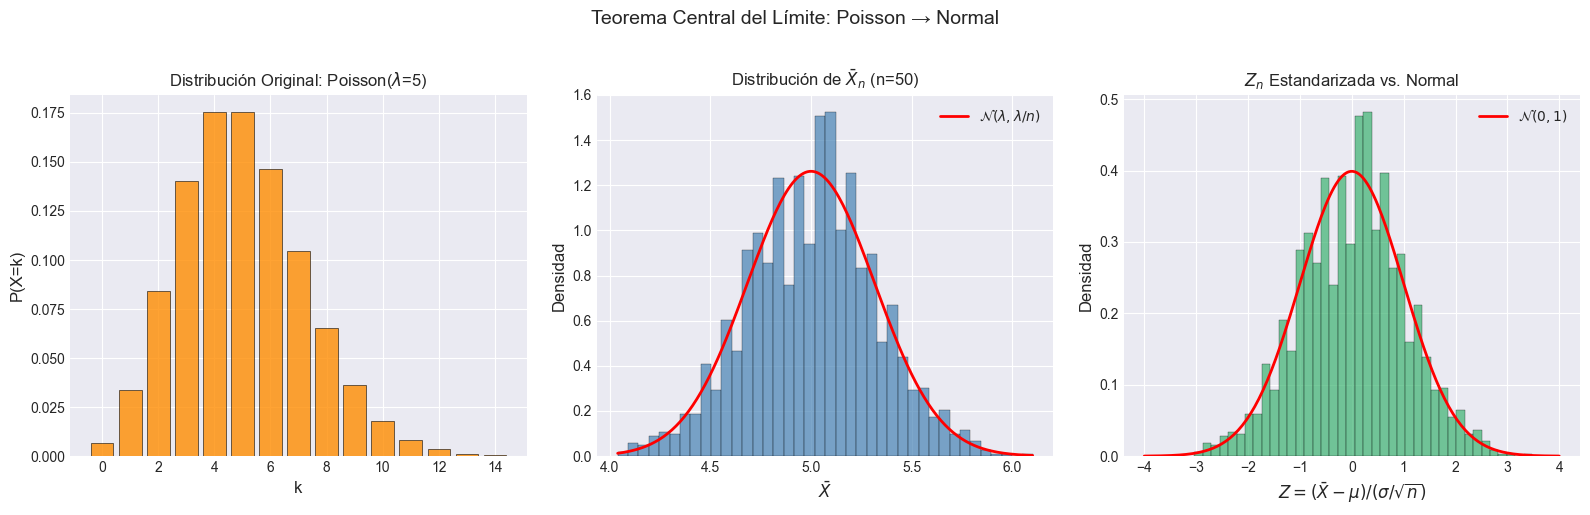

In [26]:
# CLT en acción: Medias de distribución Poisson convergen a Normal ===
# Aunque la Poisson es discreta y asimétrica, la media muestral se vuelve Normal

lmbda = 5  # Parámetro de Poisson
n_per_sample = 50  # Tamaño de cada muestra
n_iterations = 2000  # Número de medias a calcular

# Generamos n_iterations medias de muestras Poisson de tamaño n_per_sample
sample_means = np.array([np.random.poisson(lmbda, n_per_sample).mean() for _ in range(n_iterations)])

# Estandarizamos: Z = (X̄ - μ) / (σ/√n)
z_scores = (sample_means - lmbda) / np.sqrt(lmbda / n_per_sample)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribución original (Poisson)
k_vals = np.arange(0, 15)
pmf_vals = stats.poisson.pmf(k_vals, lmbda)
axes[0].bar(k_vals, pmf_vals, color='darkorange', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0].set_title(f'Distribución Original: Poisson($\\lambda$={lmbda})', fontsize=12)
axes[0].set_xlabel('k')
axes[0].set_ylabel('P(X=k)')

#Distribución medias muestrales
axes[1].hist(sample_means, bins=40, density=True, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
x_sm = np.linspace(sample_means.min(), sample_means.max(), 200)
pdf_sm = stats.norm.pdf(x_sm, lmbda, np.sqrt(lmbda/n_per_sample))
axes[1].plot(x_sm, pdf_sm, 'r-', linewidth=2, label=f'$\\mathcal{{N}}(\\lambda, \\lambda/n)$')
axes[1].set_title(f'Distribución de $\\bar{{X}}_{{n}}$ (n={n_per_sample})', fontsize=12)
axes[1].set_xlabel('$\\bar{X}$')
axes[1].set_ylabel('Densidad')
axes[1].legend()

# Distribución estandarizada vs Normal(0,1)
axes[2].hist(z_scores, bins=40, density=True, color='mediumseagreen', alpha=0.7, edgecolor='black', linewidth=0.3)
x_z = np.linspace(-4, 4, 200)
axes[2].plot(x_z, stats.norm.pdf(x_z), 'r-', linewidth=2, label='$\\mathcal{N}(0, 1)$')
axes[2].set_title('$Z_n$ Estandarizada vs. Normal', fontsize=12)
axes[2].set_xlabel('$Z = (\\bar{X} - \\mu) / (\\sigma/\\sqrt{n})$')
axes[2].set_ylabel('Densidad')
axes[2].legend()

plt.suptitle('Teorema Central del Límite: Poisson → Normal', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Más Muestras → Más Confianza

La varianza de la media muestral se reduce con $n$:

$$
\text{Var}(\bar{X}_n) = \frac{\sigma^2}{n}
$$

Esto es lo que garantiza la convergencia de la LLN, y lo que hace que el CLT sea cada vez más preciso. A mayor $n$, la campana se estrecha alrededor de $\mu$.

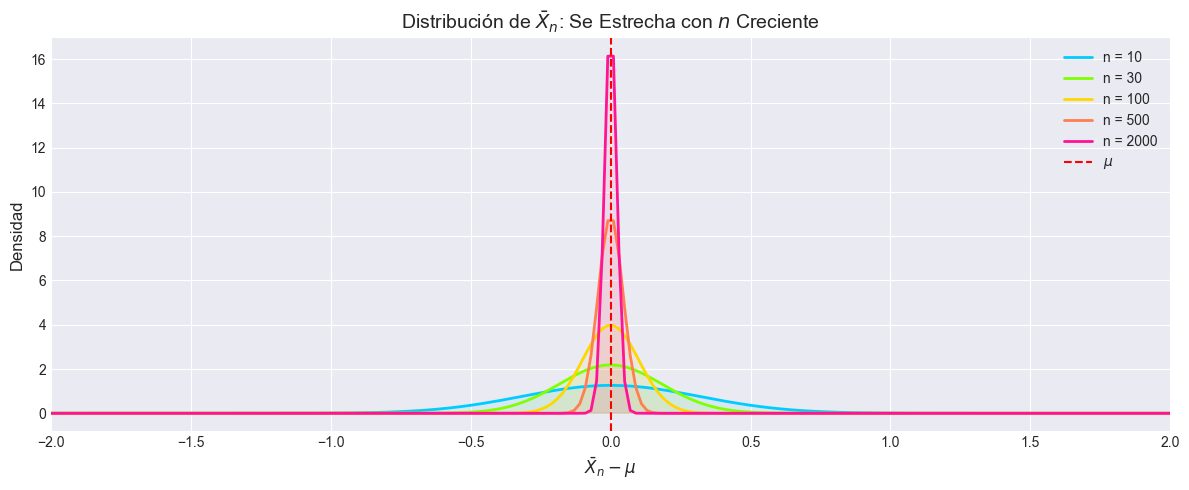

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))

sample_sizes_clt = [10, 30, 100, 500, 2000]
colors_clt = ['#00CCFF', '#7FFF00', '#FFD700', '#FF7F50', '#FF1493']
x_clt = np.linspace(-4, 4, 400)

for n_clt, color in zip(sample_sizes_clt, colors_clt):
    se = 1.0 / np.sqrt(n_clt)  # σ=1 para visualización
    pdf = stats.norm.pdf(x_clt, 0, se)
    ax.plot(x_clt, pdf, color=color, linewidth=2, label=f'n = {n_clt}')
    ax.fill_between(x_clt, pdf, alpha=0.08, color=color)

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='$\\mu$')
ax.set_title('Distribución de $\\bar{X}_n$: Se Estrecha con $n$ Creciente', fontsize=14)
ax.set_xlabel('$\\bar{X}_n - \\mu$')
ax.set_ylabel('Densidad')
ax.legend(fontsize=10)
ax.set_xlim([-2, 2])

plt.tight_layout()
plt.show()

### La Media Acumulada de NVDA por Períodos

Si la media fuera una constante del universo (como $\pi$), veríamos convergencia estable independientemente del período. Veamos qué pasa cuando miramos la media acumulada en años distintos.

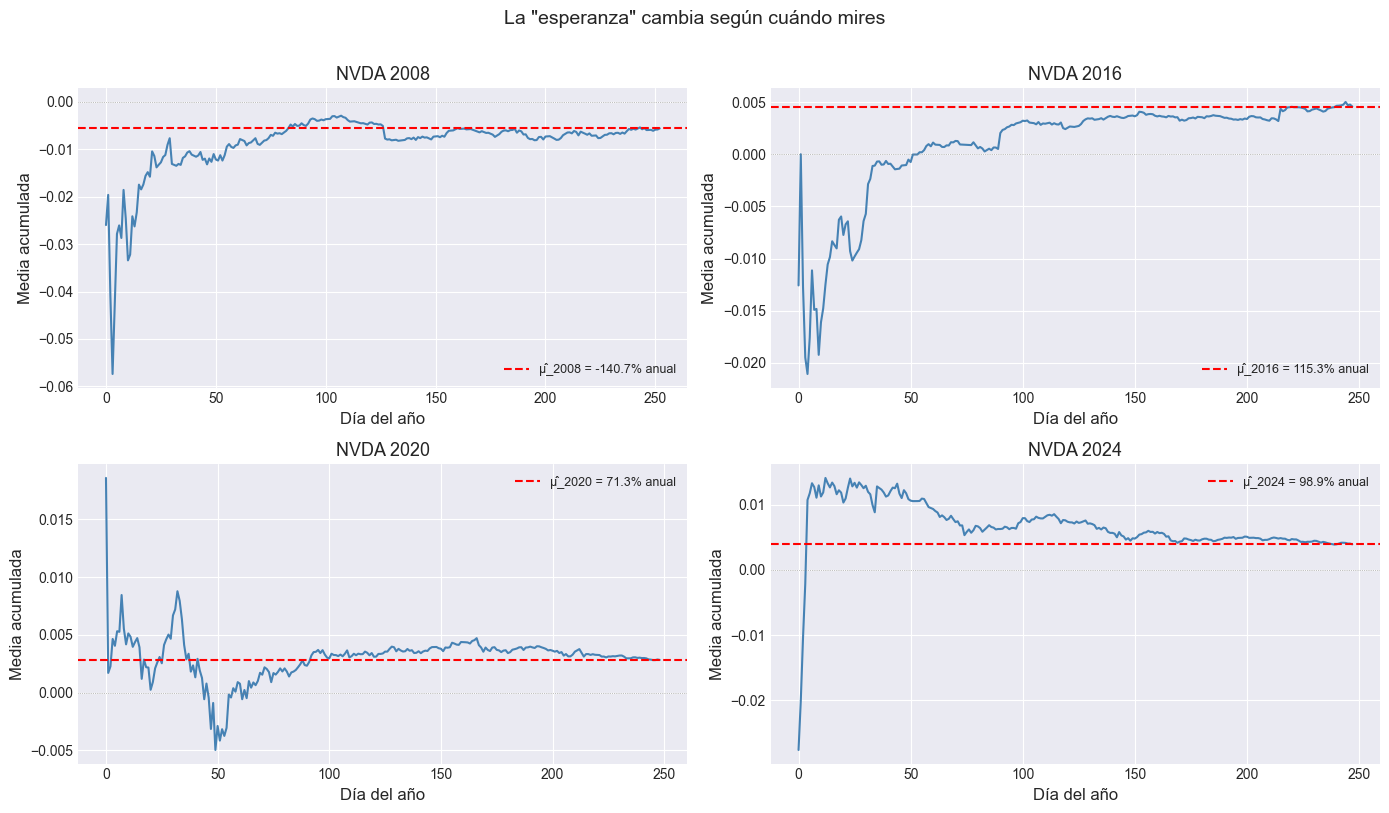

In [27]:
# Media acumulada por ventanas de tiempo
# Mostramos que la media a la que "converge" depende del período

years_to_show = [2008, 2016, 2020, 2024]
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for idx, year in enumerate(years_to_show):
    ax = axes[idx // 2, idx % 2]
    mask = df.index.year == year
    year_returns = df.loc[mask, 'Log_Return'].values
    
    if len(year_returns) > 0:
        cum_mean_year = np.cumsum(year_returns) / np.arange(1, len(year_returns) + 1)
        ax.plot(cum_mean_year, color='steelblue', linewidth=1.5)
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=0.5)
        ax.axhline(y=year_returns.mean(), color='red', linestyle='--', 
                   label=f'μ̂_{year} = {year_returns.mean()*252*100:.1f}% anual')
        ax.set_title(f'NVDA {year}', fontsize=13)
        ax.set_xlabel('Día del año')
        ax.set_ylabel('Media acumulada')
        ax.legend(fontsize=9)

plt.suptitle('La "esperanza" cambia según cuándo mires', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### ¿Por qué el CLT "falla" con los retornos?

El CLT no falla, nosotros violamos sus supuestos. Repasemos:

| Supuesto del CLT | ¿Se cumple en los mercados? |
|------|------|
| Las $X_i$ son **independientes** | Aproximadamente, pero hay clustering de volatilidad (GARCH) |
| Las $X_i$ son **idénticamente distribuidas** | **NO.** $\mu$ y $\sigma$ cambian con el tiempo (no estacionariedad) |
| La varianza $\sigma^2$ **existe y es finita** | Probablemente sí, pero las fat tails lo ponen en duda |

El problema fundamental es la **no estacionariedad**: la distribución generadora cambia con el tiempo. Lo que la LLN y el CLT estiman es un promedio sobre **múltiples regímenes**, no el parámetro de una distribución fija.

### Pero el CLT sigue siendo útil...

Aunque a largo plazo la distribución cambia, el CLT nos ofrece una **fotografía local**. En una ventana temporal corta (días, semanas), la distribución puede ser razonablemente estable.

**Ejemplo práctico:** Si un quant evalúa el sentimiento de 50 documentos sobre una acción a las 9:15am, el CLT permite evaluar la probabilidad de que la señal observada sea "ruido" vs. una señal real — asumiendo que la distribución de sentimiento es estable durante esos minutos. Y esa asunción es **mucho más razonable** que asumir estabilidad durante 25 años.

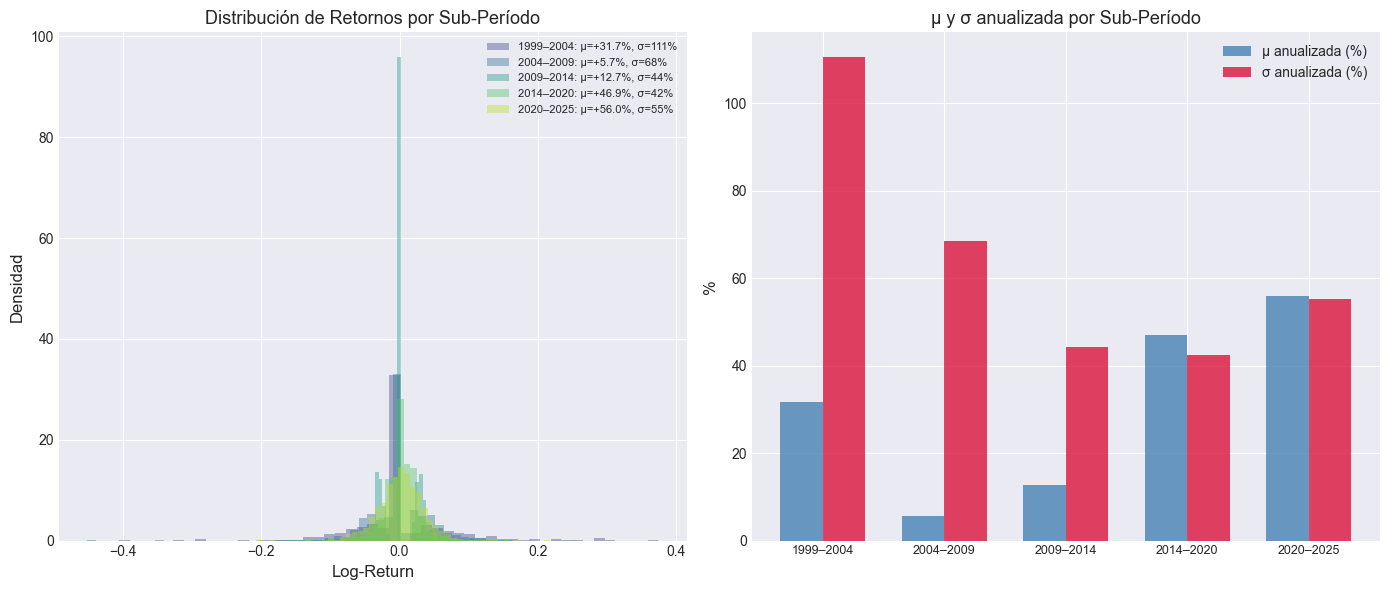

In [29]:
# === Visualización Final: Distribución que cambia con el tiempo ===
# La Normal que asumimos es fija, pero la realidad es un objetivo móvil

# divide NVDA en 5 sub-períodos y comparamos distribuciones
n_periods = 5
period_size = len(returns) // n_periods
colors_per = plt.cm.viridis(np.linspace(0.2, 0.9, n_periods))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# densidades por período superpuestas
for i in range(n_periods):
    period_ret = returns[i*period_size:(i+1)*period_size]
    start_date = df.index[i*period_size].year
    end_date = df.index[min((i+1)*period_size - 1, len(df)-1)].year
    
    axes[0].hist(period_ret, bins=50, density=True, alpha=0.4, color=colors_per[i], 
                 label=f'{start_date}–{end_date}: μ={period_ret.mean()*252*100:+.1f}%, σ={period_ret.std()*np.sqrt(252)*100:.0f}%')

axes[0].set_title('Distribución de Retornos por Sub-Período', fontsize=13)
axes[0].set_xlabel('Log-Return')
axes[0].set_ylabel('Densidad')
axes[0].legend(fontsize=8)

#media y sigma por período
period_mus = []
period_sigmas = []
period_labels = []
for i in range(n_periods):
    period_ret = returns[i*period_size:(i+1)*period_size]
    start_date = df.index[i*period_size].year
    end_date = df.index[min((i+1)*period_size - 1, len(df)-1)].year
    period_mus.append(period_ret.mean() * 252 * 100)
    period_sigmas.append(period_ret.std() * np.sqrt(252) * 100)
    period_labels.append(f'{start_date}–{end_date}')

x_pos = np.arange(n_periods)
width = 0.35
bars1 = axes[1].bar(x_pos - width/2, period_mus, width, color='steelblue', alpha=0.8, label='μ anualizada (%)')
bars2 = axes[1].bar(x_pos + width/2, period_sigmas, width, color='crimson', alpha=0.8, label='σ anualizada (%)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(period_labels, fontsize=9)
axes[1].set_title('μ y σ anualizada por Sub-Período', fontsize=13)
axes[1].set_ylabel('%')
axes[1].legend()
axes[1].axhline(y=0, color='white', linewidth=0.5)

plt.tight_layout()
plt.show()

- Los parámetros (μ, σ) cambian DRÁSTICAMENTE entre períodos.
- No existe una 'única' distribución fija de retornos de NVDA.
- El GBM, la LLN y el CLT son herramientas útiles pero operan bajo supuestos que la realidad viola.